# 1. 数据处理
## 1.1 对于txt数据的处理
1. 处理txt：每100ms上报一个数据，每个数据包含多个字段，详见论文的APPENDIXES B – DATASET INFO；但我们用得到的主要就是以下3个字段：EpochTime\BufferHealth\PlaybackQuality

2. | Relative Time| Packets Sent |Packets Sent|Bytes Sent|Bytes Received|[NetworkInfo N]|[Playback Info]
| --- | --- |---|
|相对时间标志着间隔的结束| 1|1|1|1| 7x26|4+4+9+3

3. 其中`NetworkInfo N`中包含7和字段，一共有26组
4. `Playback Info`中有4+4+9+3个字段，是我们需要注意的分类标签

In [3]:
import glob

import numpy as np
import pandas as pd
import os

## 清理原始数据

In [10]:
# 清理原始数据
# 规范：全局变量使用首字母大写
Dataset_List = ['A0', 'A1', 'A2', 'A3']
Datasets_Folder = "RequetDataSetNew"
Data_Num_In_Folder = {
    'A0':95,
    'A1':130,
    'A2':91,
    'A3':119
}
Label_Folder = "LabelDataSet"

for datasets in Dataset_List:
    dataset_folder = f'{Datasets_Folder}/{datasets}/MERGED_FILES/'
    files = glob.glob(dataset_folder + '*.csv')
    for file in files:
        # print(file)
        os.remove(file)

In [5]:
# 构建前五个col
COLS = ['RelativeTime', 'PacketsSent', 'PacketsReceived', 'BytesSent', 'BytesReceived']
Network_Info_Num = 26 # 一共26个NetworkINFO
for i in range(0, Network_Info_Num):
    ss = str(i)
    Network_Info = ['IPSrc' + ss,
                    'IPDst' + ss,
                    'Protocol' + ss,
                    'PacketsSent' + ss,
                    'PacketsReceived' + ss,
                    'BytesSent' + ss,
                    'BytesReceived' + ss]
    COLS.extend(Network_Info)
COLS.extend(['Buffering', 'Paused', 'Playing', 'CollectData']);
COLS.extend(['EpochTime','StartTime', 'PlaybackProgress', 'Length']);
COLS.extend(['UnlabelledQuality', 'q144p', 'q240p','q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']);
COLS.extend(['BufferHealth', 'BufferProgress', 'BufferValid'])
# 验证构建正确性
TARGET_NUM_COLS = 5 + 7 * 26 + (4 + 4 + 9 + 3)
if len(COLS) != TARGET_NUM_COLS:
    raise Exception(f"Error number of columns {len(COLS)}, targat columns is {TARGET_NUM_COLS} ")
else:
    print(f"Succeed to construct COL:{len(COLS)}")


Succeed to construct COL:207


## 1.2 加载txt

In [87]:
import concurrent.futures
MAX_WORKERS = 20
def Conactenat(file):
    csv_filename = f"{Label_Folder}/{datasets}/{os.path.split(file)[1]}".split('.')[0] + ".csv"
    # print(csv_filename)
    origin_file = open(file, "rt")
    csv_file = open(csv_filename, "wt")
    for line in origin_file:
        csv_file.write(line.replace('[', '').replace(']', ''))
    origin_file.close()
    csv_file.close()
    df = pd.read_csv(csv_filename, header=None, low_memory=False)
    df.columns = 207
    df.to_csv(csv_filename, index=False)
    # percent = round(1.0 * i / total * 100,2)
    # print(f'Concatenating{datasets} : {str(percent)}% ,[{i}/{total}]',end='\r')
    # i = i + 1

In [6]:
### 等会删掉
import time
Dataset_List = ['A0']
###
start = time.time()
for datasets in Dataset_List:
    dataset_folder = f'{Datasets_Folder}/{datasets}/MERGED_FILES/'
    files = glob.glob(dataset_folder + '*_*_merged.txt')
    if len(files) != Data_Num_In_Folder[datasets]:
        raise Exception(f"Error File Num,Please Check Folder :{dataset_folder}")
    else:
        print(f"Folder : {dataset_folder} , File Num : {len(files)}")
    i = 1
    os.system(f"md {Label_Folder}\\{datasets}")
    total = len(files)
    for file in files:
        csv_filename = f"{Label_Folder}/{datasets}/{os.path.split(file)[1]}".split('.')[0] + ".csv"
        # print(csv_filename)
        origin_file = open(file, "rt")
        csv_file = open(csv_filename, "wt")
        for line in origin_file:
            csv_file.write(line.replace('[', '').replace(']', ''))
        origin_file.close()
        csv_file.close()
        df = pd.read_csv(csv_filename, header=None, low_memory=False)
        df.columns = COLS
        # print("Concatenating (", i, "/", len(files), "): ", file)
        df.to_csv(csv_filename, index=False)
        percent = round(1.0 * i / total * 100,2)
        print(f'Concatenating{datasets} : {str(percent)}% ,[{i}/{total}]',end='\r')
        i = i + 1
print("******Concatenated All Folder!*******")
end = time.time()
print(f"Use {end - start}s")


Folder : RequetDataSetNew/A0/MERGED_FILES/ , File Num : 95
******Concatenated All Folder!*******
Use 35.65719985961914s


In [170]:
# ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']状态对照表
def smooth_status(status_origin, m_t):
    # print("SMOOTH")
    status_smooth = status_origin.copy()
    now_index = 0
    # last_index = 0
    while now_index < len(status_smooth):
        if status_smooth[now_index] == 0:
            last_index = now_index
            end = min(len(status_smooth), now_index + MinTime_stall * 10 + 1) # 找到在其后面MinTimeStall的所有status
            for j in range(now_index + 1, end):
                if status_smooth[j] == 0:
                    last_index = j
            for j in range(now_index + 1, last_index + 1):
                status_smooth[j] = 0
            if last_index != now_index:
                now_index = last_index
            else:
                now_index = now_index + 1
        else:
            now_index = now_index + 1

    now_index = 0
    while now_index < len(status_smooth):
        if status_smooth[now_index] == 1:
            last_index = now_index
            end = min(len(status_smooth), now_index + MinTime_stall * 10 + 1)
            for j in range(now_index + 1, end):
                if status_smooth[j] == 1:
                    last_index = j
            for j in range(now_index + 1, last_index + 1):
                status_smooth[j] = 1
            if last_index != now_index:
                now_index = last_index
            else:
                now_index = now_index + 1
        else:
            now_index = now_index + 1

    num = [0 for _ in range(len(status_smooth))]
    num[0] = 1
    for now_index in range(1, len(status_smooth)):
        if status_smooth[now_index] == 1:
            if status_smooth[now_index - 1] == 1:
                num[now_index] = num[now_index - 1] + 1
            else:
                num[now_index] = 1
                if num[now_index - 1] <= Thr_ss * 10:
                    for j in range(now_index - 1, -1, -1):
                        if status_smooth[j] == 1:
                            status_smooth[j] = 3 if m_t[j] >= 0 else 2
                            print("change")
                        else:
                            break
    return status_smooth

In [204]:
Dataset_List = ['A0', 'A1', 'A2', 'A3']
for datasets in Dataset_List:
    dataset_folder = f'{Label_Folder}/{datasets}/'
    files = glob.glob(dataset_folder + '*_label.csv')
    for file in files:
        # print(file)
        os.remove(file)

In [179]:
import numpy as np
 ### 等会删掉
Dataset_List = ['A0']
###

Sum = 0
Num = [0 for _ in range(0, 4)]

MinTime_stall = 10
Thr_ss = 15
Resolution_List = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']
Status_List = ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']

Stall_Threshold = 0.08
Delta = 0.0001
Epsilon = 0.15
T_smooth = 15
T_slope = 5
Buff_ss = 10
BuffWarningThresh = 20
start = time.time()
for datasets in Dataset_List:
    dataset_folder = f'{Label_Folder}/{datasets}/' # 寻找到已经存为CSV的文件夹，在test_data下
    files = glob.glob(dataset_folder + '*_merged.csv')
    files = files[0:1]
    for file in files:
        file_id = file.split('.')[0]
        df = pd.read_csv(file,low_memory=False)
        hat_b = {}
        m = []
        status = []
        array_label=[]
        ## 要使用的存储df
        numpy_RelativeTime = np.array(df['RelativeTime'])
        numpy_BufferHealth = np.array(df['BufferHealth'])
        numpy_BufferValid = np.array(df["BufferValid"])
        numpy_EpochTime = np.array(df["EpochTime"])
        numpy_Resolution = np.array(df[Resolution_List])
        for i in numpy_RelativeTime:
            # print(i)
            # print(numpy_BufferHealth[(numpy_row >= (i- T_smooth - Delta)) & (numpy_row <= (i+ T_smooth + Delta))])
            hat_b[round(i * 10) / 10]=np.median(numpy_BufferHealth[(numpy_RelativeTime >= (i - T_smooth - Delta)) & (numpy_RelativeTime <= (i + T_smooth + Delta))])
        # # # print(df['RelativeTime'])
        # # for index, row in df.iterrows(): # 遍历行
        # #     hat_b[round(row['RelativeTime'] * 10) / 10] = df[(df['RelativeTime'] >= row['RelativeTime'] - T_smooth - Delta) & (
        # #             df['RelativeTime'] <= row['RelativeTime'] + T_smooth + Delta)].BufferHealth.median()
        maxTime = round(numpy_RelativeTime.max() * 10) / 10 # df的最后一个relativeTime的值
        for i in range(len(numpy_RelativeTime)):
            if numpy_BufferValid[i] == "-1":
                continue
            if i > 0:
                if numpy_EpochTime[i] == numpy_EpochTime[i-1] or 0 == numpy_EpochTime[i-1]:
                    continue
            new_row=[]
            new_row.append(numpy_EpochTime[i])
            t = numpy_RelativeTime[i]
            t_slope_1 = round((t + T_slope) * 10) / 10
            t_slope_2 = round((t - T_slope) * 10) / 10
            # 将t_slope卡在[0,maxTime]之间
            if t_slope_1 > maxTime:
                t_slope_1 = maxTime
            if t_slope_2 < 0:
                t_slope_2 = 0
            Resolution = 0
            for j in range(len(Resolution_List)):
                if numpy_Resolution[i,j] == 1:
                    Resolution = j
                    break
            mt = (hat_b[t_slope_1] - hat_b[t_slope_2]) / (t_slope_1 - t_slope_2)
            m.append(mt)
            b_t = numpy_BufferHealth[i]

            # BuffWarningThresh 以20作为分类标准 第71:6页
            if b_t < BuffWarningThresh:
                new_row.append(1)
                # np.append(new_row,1)
            else:
                new_row.append(0)
            if b_t < Stall_Threshold:
                state = 0
            elif -Epsilon <= mt <= Epsilon and b_t > Buff_ss:
                state = 1
            elif mt < 0:
                state = 2
            else:
                state = 3
            Sum = Sum + 1
            Num[state] = Num[state] + 1
            new_row.append(state)
            status.append(state)
            new_row.append(Resolution)
            # df_new.loc[len(df_new)] = new_row
            array_label.append(new_row)

        df_new = pd.DataFrame(array_label,columns=["EpochTime",  "BuffWarning", "status", "Resolution"])
        # start = time.time()
        # status = smooth_status(status, m)
        # end = time.time()
        # df_new['status'] = status
        print(df_new.iloc[1150:1155])
        # # df_new['BuffWarning'] = BuffWarnings
        # # df_new['Resolution'] = Resolutions
        # # print(df_new)
        df_new.to_csv(file_id + '_label.csv', index=None, header=True)
        print(file_id + '_tag.csv')

print(f"Use {end - start}s")

          EpochTime  BuffWarning  status  Resolution
1150  1516209742696            0       1           4
1151  1516209742796            0       1           4
1152  1516209742896            0       1           4
1153  1516209742995            0       1           4
1154  1516209743096            0       1           4
LabelDataSet/A0\baseline_Jan17_exp_31_merged_tag.csv
Use -189.5323450565338s


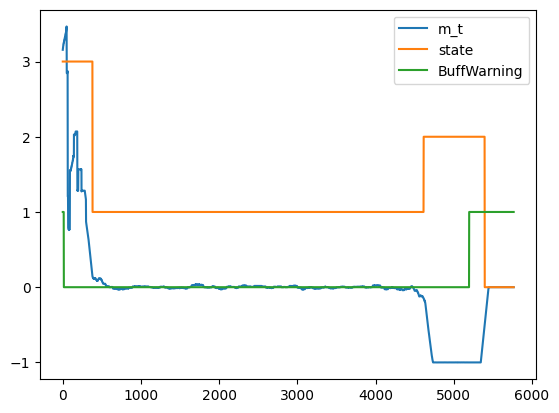

In [202]:
import matplotlib.pyplot as plt
# Status_List = ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']
plt.plot(m,label='m_t')
plt.plot(status,label='state')
plt.plot(df_new["BuffWarning"],label='BuffWarning')
plt.legend()

In [152]:
import numpy as np
 ### 等会删掉
Dataset_List = ['A0']
###


Sum = 0
Num = [0 for _ in range(0, 4)]

MinTime_stall = 10
Thr_ss = 15
Resolution_List = ['q144p', 'q240p', 'q360p', 'q480p', 'q720p', 'q1080p', 'q1440p', 'q2160p']
Status_List = ['Stall', 'Steady State', 'Buffer Decay', 'Buffer Increase']

Stall_Threshold = 0.08
Delta = 0.0001
Epsilon = 0.15
T_smooth = 15
T_slope = 5
Buff_ss = 10
BuffWarningThresh = 20
start = time.time()
for datasets in Dataset_List:
    dataset_folder = f'{Label_Folder}/{datasets}/' # 寻找到已经存为CSV的文件夹，在test_data下
    files = glob.glob(dataset_folder + '*.csv')
    files = files[0:1]
    for file in files:
        file_id = file.split('.')[0]
        df = pd.read_csv(file,low_memory=False)
        df_new = pd.DataFrame(columns=["EpochTime",  "BuffWarning", "status", "Resolution"])
        # Stall_Threshold = 0.08 #delta
        # Delta = 0.0001
        # Epsilon = 0.15
        # T_smooth = 15
        # T_slope = 5
        # Buff_ss = 10
        # BuffWarningThresh = 20
        hat_b = {}
        m = []
        status = []
        ## 要使用的存储df
        numpy_Resolution = np.array(df[Resolution_List])
        for i in numpy_RelativeTime:
            hat_b[round(i * 10) / 10]=np.median(numpy_BufferHealth[(numpy_RelativeTime >= (i - T_smooth - Delta)) & (numpy_RelativeTime <= (i + T_smooth + Delta))])
        maxTime = round(numpy_RelativeTime.max() * 10) / 10 # df的最后一个relativeTime的值
        for index, row in df.iterrows():
            if row["BufferValid"] == "-1":
                continue
            if index > 0:
                if row["EpochTime"] == df.iloc[index - 1]["EpochTime"] or 0 == df.iloc[index - 1]["EpochTime"]:
                    continue
            new_row = [row["EpochTime"]]
            t = round(row['RelativeTime'] * 10) / 10
            t_slope_1 = round((t + T_slope) * 10) / 10
            t_slope_2 = round((t - T_slope) * 10) / 10

            if t_slope_1 > maxTime:
                t_slope_1 = maxTime
            if t_slope_2 < 0:
                t_slope_2 = 0
        #     # print(t_slope_1, t_slope_2)
            Resolution = 0
            for i in range(len(Resolution_List)):
                if row[Resolution_List[i]] == 1:
                    Resolution = i
                    break
        #     # Resolutions.append(Resolution)
            # 计算mt
            mt = (hat_b[t_slope_1] - hat_b[t_slope_2]) / (t_slope_1 - t_slope_2)
            m.append(mt)
            b_t = row['BufferHealth']

            # BuffWarningThresh 以20作为分类标准 第71:6页
            if b_t < BuffWarningThresh:
                new_row.append(1)
            else:
                new_row.append(0)
            if b_t < Stall_Threshold:
                state = 0
            elif -Epsilon <= mt <= Epsilon and b_t > Buff_ss:
                state = 1
            elif mt < 0:
                state = 2
            else:
                state = 3
            Sum = Sum + 1
            Num[state] = Num[state] + 1
            new_row.append(state)
            status.append(state)
            new_row.append(Resolution)
            df_new.loc[len(df_new)] = new_row
        status = smooth_status(status, m)
        df_new['status'] = status
        print(df_new.iloc[1150:1155])
        # # df_new['BuffWarning'] = BuffWarnings
        # # df_new['Resolution'] = Resolutions
        # # print(df_new)
        # df_new.to_csv(file_id + '_label.csv', index=None, header=True)
        # print(file_id + '_tag.csv')
end = time.time()
print(f"Use {end - start}s")

600.9
          EpochTime  BuffWarning  status  Resolution
1150  1516209742696            0       1           4
1151  1516209742796            0       1           4
1152  1516209742896            0       1           4
1153  1516209742995            0       1           4
1154  1516209743096            0       1           4
Use 7.4486236572265625s


In [31]:
[1516209721996, 0, 1, 4]
[1516209722097, 0, 1, 4]
[1516209722197, 0, 1, 4]
[1516209722297, 0, 1, 4]
[1516209722397, 0, 1, 4]

LabelDataSet/A0\baseline_Jan17_exp_31_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_34_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_41_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_45_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_47_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_55_merged_label.csv
LabelDataSet/A0\baseline_Jan17_exp_59_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_71_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_74_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_81_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_85_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_87_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_96_merged_label.csv
LabelDataSet/A0\baseline_Mar01_exp_99_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_71_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_74_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_81_merged_label.csv
LabelDataSet/A0\baseline_Mar02_exp_85_merged_label.csv
LabelDataS

In [122]:
df = pd.read_csv(file,low_memory=False)
df = df.iloc[0:5]

In [125]:
df.iloc[0:6]

,RelativeTime,PacketsSent,PacketsReceived,BytesSent,BytesReceived,IPSrc0,IPDst0,Protocol0,PacketsSent0,PacketsReceived0,...,q240p,q360p,q480p,q720p,q1080p,q1440p,q2160p,BufferHealth,BufferProgress,BufferValid
0,0.0,1,0,267,0,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
1,0.1,14,14,1957,6714,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
2,0.2,3,3,244,551,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
3,0.3,8,0,798,0,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1
4,0.4,3,1,600,102,192.168.1.190,173.194.7.39,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,-1


In [ ]:
import pandas as pd
import numpy as np
from scapy.all import *
from math import *

GET_THRESH = 300 # bytes
DOWN_THRESH = 300  # bytes
VIDEO_CHUNK_GETSIZE = 700 # bytes
AUDIO_CHUNK_GETSIZE = 600 # bytes
NETINFO_NUM = 25

class Chunk():
    def __init__(self, start_time = 0, server_ip='',ttfb = 0, download_time = 0, slack_time = 0, get_size=0, chunk_size = 0, type="", protocol=""):
        self.start_time = start_time
        self.server_ip = server_ip
        self.ttfb = ttfb
        self.download_time = download_time
        self.slack_time = slack_time
        self.get_size = get_size
        self.chunk_size = chunk_size
        self.type = type
        self.protocol = protocol
    def __str__(self):
        return f"{self.start_time} {self.ttfb} {self.download_time} {self.slack_time} {self.get_size} {self.chunk_size} {self.type} {self.protocol}"
    def __repr__(self):
        return f"{self.start_time} {self.ttfb} {self.download_time} {self.slack_time} {self.get_size} {self.chunk_size} {self.type} {self.protocol}"


def isUplink(p):
    # IP = scapy.layers.inet.IP
    return p[IP].src.startswith('192.168.')

def detectAV(c):
    if abs(c.get_size-VIDEO_CHUNK_GETSIZE) > abs(c.get_size-AUDIO_CHUNK_GETSIZE):
        flag=0
    else:
        flag=1
    if c.chunk_size<=80*1024:
        flag=2
    return flag

def chunkDetection(filename):
    a = rdpcap(filename)
    meta_time = float(a[0].time)
    chunk = {}
    chunks = []
    downFlag = {}
    # IP = scapy.layers.inet.IP
    for p in a:
        if p.haslayer(IP):
            ipSrc=p[IP].src
            ipDst=p[IP].dst
            pLen=p[IP].len
            pHdr=p[IP].ihl*4
            ip_time=float(p.time)
            if isUplink(p) and pLen-pHdr > GET_THRESH:
                if ipDst in chunk:
                    chunk[ipDst].slack_time = ip_time - chunk[ipDst].download_time
                    avFlag=detectAV(chunk[ipDst])
                    if avFlag==0:
                        # chunk[ipDst].type='a'
                        chunks.append(chunk[ipDst])
                    elif avFlag==1:
                        # chunk[ipDst].type='v'
                        chunks.append(chunk[ipDst])
                    else:
                        chunk.pop(ipDst)
                        downFlag.pop(ipDst)
                chunk[ipDst] = Chunk(start_time=ip_time, get_size=pLen-pHdr, server_ip=ipDst)
                downFlag[ipDst] = False
            elif not isUplink(p) and pLen > DOWN_THRESH:
                if ipSrc in chunk:
                    if not downFlag[ipSrc]:
                        chunk[ipSrc].ttfb = ip_time
                        downFlag[ipSrc] = True
                    chunk[ipSrc].download_time = ip_time
                    chunk[ipSrc].chunk_size += pLen - pHdr
                    chunk[ipSrc].protocol = p.proto

    for c in chunk.values():
        avFlag=detectAV(c)
        if avFlag==0:
            # c.type='a'
            chunks.append(c)
        elif avFlag==1:
            # c.type='v'
            chunks.append(c)
    return meta_time, chunks

filename = 'RequetDataSetNew/A0/PCAP_FILES/baseline_Jan17_exp_31.pcap'
meta_time, chunks=chunkDetection(filename)